In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore")

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_path = "D:\\MalariaDetection\\Cell_Images\\cell_images\\train"
test_path  = "D:\\MalariaDetection\\Cell_Images\\cell_images\\test"

In [4]:
image_shape = (130, 130, 3)

In [5]:
image_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1 ,
                               shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode = 'nearest')

In [6]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [7]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [8]:
train_image_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2], color_mode='rgb', batch_size=32, class_mode='binary')

Found 24958 images belonging to 2 classes.


In [9]:
test_image_gen = image_gen.flow_from_directory(test_path, target_size=image_shape[:2], color_mode='rgb', batch_size=32, class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [10]:
InceptionResNetV2_model = Sequential()

pretrained_model = tf.keras.applications.InceptionResNetV2(include_top=False,
                   input_shape=image_shape,
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

InceptionResNetV2_model.add(pretrained_model)

InceptionResNetV2_model.add(Flatten())
InceptionResNetV2_model.add(Dense(128, activation='relu'))
InceptionResNetV2_model.add(Dense(1, activation='sigmoid'))

In [11]:
InceptionResNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 54,533,601
Trainable params: 196,865
Non-trainable params: 54,336,736
_________________________________________________________________


In [12]:
InceptionResNetV2_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [14]:
InceptionResNetV2_model.fit(train_image_gen, epochs=50, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/50
780/780 [==============================] - 94s 106ms/step - loss: 18.3708 - accuracy: 0.5659 - val_loss: 15.2579 - val_accuracy: 0.5050
Epoch 2/50
780/780 [==============================] - 75s 96ms/step - loss: 8.5799 - accuracy: 0.5718 - val_loss: 2.1447 - val_accuracy: 0.6400
Epoch 3/50
780/780 [==============================] - 75s 97ms/step - loss: 3.1539 - accuracy: 0.5728 - val_loss: 2.4693 - val_accuracy: 0.5038
Epoch 4/50
780/780 [==============================] - 75s 96ms/step - loss: 1.4279 - accuracy: 0.5879 - val_loss: 0.9488 - val_accuracy: 0.5765
Epoch 5/50
780/780 [==============================] - 76s 97ms/step - loss: 0.8484 - accuracy: 0.5971 - val_loss: 0.9261 - val_accuracy: 0.6188
Epoch 6/50
780/780 [==============================] - 75s 96ms/step - loss: 0.6862 - accuracy: 0.6311 - val_loss: 0.6376 - val_accuracy: 0.6519
Epoch 7/50
780/780 [==============================] - 75s 96ms/step - loss: 0.6396 - accuracy: 0.6494 - val_loss: 0.6343 - val_accura

In [15]:
history = pd.DataFrame(InceptionResNetV2_model.history.history)

In [16]:
history.head()

,loss,accuracy,val_loss,val_accuracy
0,18.370787,0.565871,15.257867,0.505000
1,8.579891,0.571801,2.144710,0.640000
2,3.153893,0.572762,2.469284,0.503846
3,1.427852,0.587868,0.948791,0.576538
4,0.848403,0.597123,0.926100,0.618846


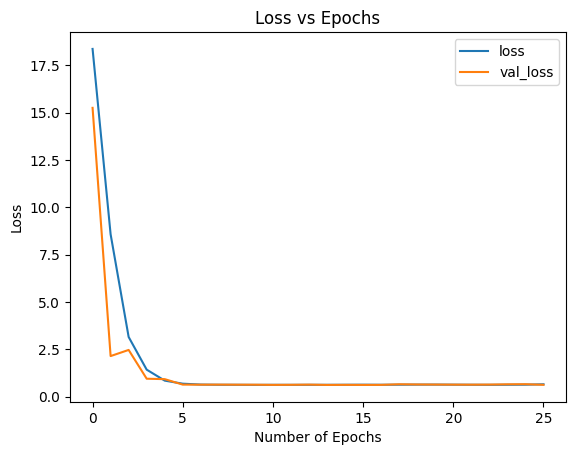

In [17]:
history[["loss", "val_loss"]].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.savefig('LossVsEpochsIRNv2.png')
plt.show()

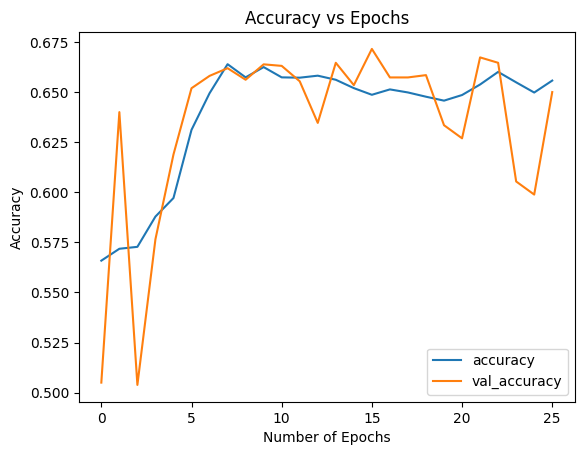

In [18]:
history[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.savefig('AccuracyvsEpochsIRnv2.png')
plt.show()

In [19]:
predictions = InceptionResNetV2_model.predict(test_image_gen)

82/82 [==============================] - 10s 89ms/step


In [20]:
predictions = predictions >= 0.5

In [21]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.63      0.78      0.70      1300
           1       0.71      0.54      0.61      1300

    accuracy                           0.66      2600
   macro avg       0.67      0.66      0.66      2600
weighted avg       0.67      0.66      0.66      2600



In [22]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1019,  281],
       [ 601,  699]], dtype=int64)

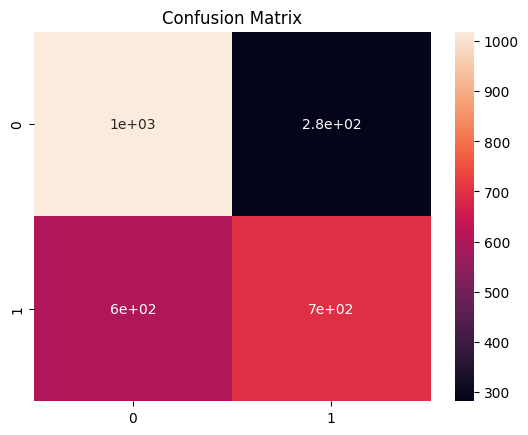

In [23]:
DetaFrame_cm = pd.DataFrame(confusion_matrix(test_image_gen.classes, predictions), range(2), range(2))
sns.heatmap(DetaFrame_cm, annot=True)
plt.title("Confusion Matrix")
plt.savefig('ConfusionMatrixHeatmapIRnv2.png')
plt.show()

In [24]:
InceptionResNetV2_model.save("MalariaPredictionsIRnv2.h5")